In [1]:
import numpy as np
import pandas as pd
import cv2 as cv
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve
import PIL
from PIL import Image

In [2]:
# load all images in a directory
from os import listdir
from matplotlib import image
from skimage.transform import resize

# load all images in a directory
loaded_images = list()
length = 597
resizeM = 32
resizeN = 64
i=0
for filename in listdir('flower_sementations/')[0:length]:
    # load image
    img_data = plt.imread('flower_sementations/' + filename)
    resized = resize(img_data,(resizeM,resizeN))
    # store loaded image
    loaded_images.append(resized)
    i+=1
                     
print("Number of images:",len(loaded_images))


Number of images: 597


In [31]:
labels = list()
file = open('flowers_labels.txt',"r")
lines = file.readlines()
for line in lines[0:length]:
    line = line.rstrip("\n")
    labels.append((int)(line))
print("Number of images:",len(labels))   

Number of images: 597


# HOG

In [4]:
#add to the list by flattening the arrays
from skimage.feature import hog
import numpy as np
hoglist = list()
for img in loaded_images:
    fd, hog_image = hog(img, orientations=9, pixels_per_cell=(8, 8), 
                    cells_per_block=(2, 2), visualize=True, multichannel=True)
    hoglist.append(np.array(hog_image).ravel())

# SIFT

In [5]:
from skimage import img_as_ubyte
import numpy as np
import cv2 as cv
siftlist = list()
for img in loaded_images:
    img = img_as_ubyte(img)
    gray = cv.cvtColor(img,cv.COLOR_BGR2GRAY)
    sift = cv.SIFT_create()
    kp = sift.detect(gray,None)
    img= cv.drawKeypoints(gray,kp,img)
    img = cv.cvtColor(img,cv.COLOR_BGR2GRAY)
    siftlist.append(np.array(img).ravel())
    

# Entropy

In [6]:
import cv2 as cv
import pandas as pd
from skimage.filters.rank import entropy
from skimage.filters import sobel
from skimage.morphology import disk
entropy_list = list()

for img in loaded_images:
    img = img_as_ubyte(img)
    gray = cv.cvtColor(img,cv.COLOR_BGR2GRAY)
    entropy_img = entropy(gray, disk(1))
    entropy_list.append(np.array(entropy_img).ravel())

## Canny Edge

In [7]:
canny_list = list()

for img in loaded_images:
    img = img_as_ubyte(img)
    edges = cv.Canny(img,100,200)
    canny_list.append(np.array(edges).ravel())


Add all features into the list


In [8]:
features = list()
features.append(np.array(canny_list))
features.append(np.array(hoglist))
features.append(np.array(siftlist))
features.append(np.array(entropy_list))

## Creating DataFrame


In [9]:
def createDF(M , N, features, labels):
    df = pd.DataFrame()
    for i in range(resizeM):
        for j in range(resizeN):    
            df['pixel_' + str(i)+ '_' +str(j)] = df.sum(axis=1, numeric_only= True)
    df_length = len(df.columns)
    for i in range(length):
        df.loc[i] = features[i]
    df.insert(df_length, "target", labels, True) 
    return df

In [10]:
#Create Data Frame for all features
dataFrames = list()
dfCanny = createDF(resizeM, resizeN, features[0], labels)
dfHog = createDF(resizeM, resizeN, features[1], labels)
dfSift = createDF(resizeM, resizeN, features[2],labels)
dfEntropy = createDF(resizeM, resizeN, features[3],labels)


In [11]:
print(f"There are {len(dfCanny['target'].unique())} label in all data which are: ", dfCanny['target'].unique())

There are 3 label in all data which are:  [77 73 88]


In [12]:
def getLabels(labels,dFrames):
    frames = list()
    for i in range(len(labels)):
        frames.append(dFrames[(dFrames['target'] == labels[i])])    
    return pd.concat(frames)

#SELECT LABELS
selectionLabels = dfCanny['target'].unique()

dfCanny =getLabels(selectionLabels,dfCanny)
dfHog =getLabels(selectionLabels,dfHog)
dfHog =getLabels(selectionLabels,dfHog)
dfEntropy =getLabels(selectionLabels,dfEntropy)

dataFrames.append(dfCanny)
dataFrames.append(dfHog)
dataFrames.append(dfSift)
dataFrames.append(dfEntropy)


## Creating Data

In [13]:
def createData(df):
    X = np.array(df.loc[:, df.columns != 'target'].values.tolist())
    y = np.array(df.loc[:, df.columns == 'target'].values.tolist()).ravel()
    return X,y

def corBetween(dFrames):
    corrs = list()
    for i in range(len(dFrames)):
        for j in range(len(dFrames)):
            cors = dFrames[i].corrwith(dFrames[j]).mean()
            corrs.append(cors)
            print(cors, end = "\t")
        print("\n")
    return corrs

def concatFeatures(selectionLists, dFrames):
    Xlist = list()
    ylist = list()
    for i in range(len(dFrames)):
        Xlist.append(createData(dFrames[i])[0])
        ylist.append(createData(dFrames[i])[1])
    for j in range(len(selectionLists)-1):
        Xlist[selectionLists[0]] = np.vstack((Xlist[selectionLists[0]],Xlist[selectionLists[j]]))
        ylist[selectionLists[0]] = np.hstack((ylist[selectionLists[0]],ylist[selectionLists[j]]))
    return Xlist[selectionLists[0]],ylist[selectionLists[0]]


In [14]:
#SELECT FEATURES
selectionFeatures = [0, 1, 3]
X, y =concatFeatures(selectionFeatures,dataFrames)

print(X.shape)
print(y.shape)

(1791, 2048)
(1791,)


## Correlation Between Datas

In [15]:
print("Correlation between datas")
corrs = corBetween(dataFrames)

Correlation between datas
1.0	0.22260501355716766	0.20311151777457637	0.4454015458636451	

0.22260501355716766	1.0	0.25907726132607684	0.47251985474098235	

0.20311151777457637	0.25907726132607684	1.0	0.5316541335191983	

0.4454015458636451	0.47251985474098235	0.5316541335191983	0.9999999999999998	



## PCA

In [32]:
from sklearn.decomposition import PCA

pca = PCA()
X = pca.fit_transform(X)

print(X.shape)

(1791, 400)


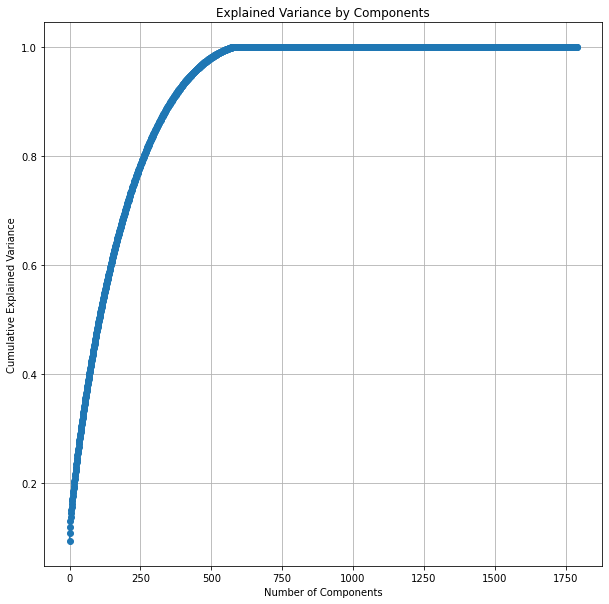

In [17]:
plt.figure(figsize = (10, 10))
plt.plot(pca.explained_variance_ratio_.cumsum(), marker = 'o', linestyle = '--') 
plt.title('Explained Variance by Components')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.grid() 

In [34]:
pca = PCA(n_components= 400)
X = pca.fit_transform(X)
X.shape


(1791, 400)

## ScaleData and Split

In [19]:
from sklearn.preprocessing import StandardScaler
#Plane datası scale edilmeli
X = StandardScaler().fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1)

### KNN

In [20]:
from sklearn.neighbors import KNeighborsClassifier
classifier = KNeighborsClassifier(n_neighbors=5)
classifier.fit(X_train, y_train)


KNeighborsClassifier()

In [21]:
y_pred = classifier.predict(X_test)

In [22]:
from sklearn.metrics import classification_report, confusion_matrix
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

[[37 16 13]
 [ 9 58 15]
 [ 5 11 16]]
              precision    recall  f1-score   support

          73       0.73      0.56      0.63        66
          77       0.68      0.71      0.69        82
          88       0.36      0.50      0.42        32

    accuracy                           0.62       180
   macro avg       0.59      0.59      0.58       180
weighted avg       0.64      0.62      0.62       180



In [23]:
error = []

for i in range(1, 40):
    knn = KNeighborsClassifier(n_neighbors=i)
    knn.fit(X_train, y_train)
    pred_i = knn.predict(X_test)
    error.append(np.mean(pred_i != y_test))

Text(0, 0.5, 'Mean Error')

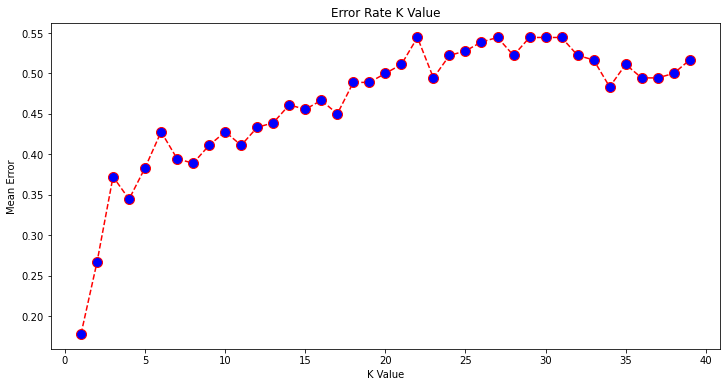

In [24]:
plt.figure(figsize=(12, 6))
plt.plot(range(1, 40), error, color='red', linestyle='dashed', marker='o',
         markerfacecolor='blue', markersize=10)
plt.title('Error Rate K Value')
plt.xlabel('K Value')
plt.ylabel('Mean Error')

## Logistic


In [25]:
from sklearn.linear_model import LogisticRegression

logreg = LogisticRegression(solver='liblinear', random_state=0)
logreg.fit(X_train,y_train)

y_pred=logreg.predict(X_test)


In [26]:
print("Train Acc: ",logreg.score(X_train, y_train))
print("Test Acc: ",logreg.score(X_test, y_test))
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

Train Acc:  0.7970204841713222
Test Acc:  0.8055555555555556
[[42 24  0]
 [ 2 80  0]
 [ 0  9 23]]
              precision    recall  f1-score   support

          73       0.95      0.64      0.76        66
          77       0.71      0.98      0.82        82
          88       1.00      0.72      0.84        32

    accuracy                           0.81       180
   macro avg       0.89      0.78      0.81       180
weighted avg       0.85      0.81      0.80       180



## Random Forest

In [27]:
from sklearn.ensemble import RandomForestClassifier

randomfor=RandomForestClassifier(n_estimators=100)

randomfor.fit(X_train,y_train)

y_pred=randomfor.predict(X_test)

In [28]:
from sklearn import metrics
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

Accuracy: 0.8777777777777778
[[56  5  5]
 [ 3 78  1]
 [ 2  6 24]]
              precision    recall  f1-score   support

          73       0.92      0.85      0.88        66
          77       0.88      0.95      0.91        82
          88       0.80      0.75      0.77        32

    accuracy                           0.88       180
   macro avg       0.86      0.85      0.86       180
weighted avg       0.88      0.88      0.88       180

